<a href="https://colab.research.google.com/github/enVives/Caltech101/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [881]:
from itertools import filterfalse
from collections import OrderedDict
import torch,torchvision
import numpy as np
import pandas as pd
import math
import cv2
import time
import os
import wandb
import pylab as pl
import scipy.io
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from torchvision import transforms,models
from torch import nn
from IPython.display import clear_output,display
from torch.utils.data import DataLoader, random_split,Subset,Dataset
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from glob import glob

ROOT = './sample_data/'
CLASS_A = 'cougar_body'
CLASS_B = 'windsor_chair'

DOWNLOAD = False
wandb.login()
#471be466c8949671a46c67e7aad0d5a0ac8c9dad
#!rm -rf /content/sample_data/*
# torch.cuda.default_stream(torch.device('cuda'))

True

In [882]:
def find_mean_std(dataset):
  dataloader = DataLoader(dataset,batch_size = 1,shuffle=FALSE)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  samples = 0

  for image,_ in dataloader:
    mean += image.mean(dim=[0, 2, 3])  # Mean for each channel [batchsize,channels,height,width]
    std += image.std(dim=[0, 2, 3])    # Std for each channel
    samples += 1

  mean /= samples
  std /= samples

  print(mean)
  print(std)

In [883]:
from pickle import NONE

class Formes(Dataset):
    def __init__(self, paths, labels= None, transforms = None,annotations = None,transform_mask = None):
        self.images = paths
        self.labels = labels
        self.transforms = transforms
        self.annotations = annotations
        self.transforms_mask = transform_mask

    def __len__(self):
        return len(self.labels)

    def __setmodel__(self,model):
        self.model = model

    def __getdist__(self):
      return pd.Series(self.labels).value_counts()

    def __showcontours__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      plt.imshow(image)

      mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

      polygons_data = mat_data['obj_contour']

      x_points = polygons_data[0]
      y_points = polygons_data[1]

      contour_points = np.array(list(zip(x_points,y_points)))

      plt.plot(contour_points[:, 0], contour_points[:, 1], '-r')  # Red contour line
      plt.scatter(contour_points[:, 0], contour_points[:, 1], c='blue')  # Optional: Mark contour points
      plt.show()

    def __getpureimage__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      return image

    def __getitem__(self, index):
      path = self.images[index]
      label = self.labels[index]

      seed = torch.random.seed()  # Create a unique seed for random operations

      if self.annotations != None:
        mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

        polygons_data = mat_data['obj_contour']
        boundingbox_data = mat_data['box_coord']

        x_points = polygons_data[0]
        y_points = polygons_data[1]

        contour_points = list(zip(x_points,y_points))
        contour = np.array(contour_points, dtype=np.int32)

        #print(contour_points)


      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if self.model == 3:
        mask = np.zeros(image.size, dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=255)  # White filled polygon
        mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image

        torch.random.manual_seed(seed)  # Set seed for image
        mask_resized = self.transforms_mask(mask)
        mask_resized = (mask_resized > 0.5).float()

        torch.random.manual_seed(seed)  # Set seed for image
        image = self.transforms(image)

        return image, mask_resized

      image = self.transforms(image)

      return image, label

In [884]:
def get_labels(sett):
  labels = np.array([])
  frequency = np.zeros(101)
  for _,label in sett:
    labels = np.append(labels,label)
    frequency[label] += 1
  return labels.astype(int),frequency

In [885]:
#from pickle import FALSE
from sklearn.model_selection import train_test_split

TRAINING = 0.80
VAL = 0.10
TESTING = 0.10

#[0.5459, 0.5288, 0.5022]
#[0.2424, 0.2393, 0.2409]
mean = torch.tensor([0.485,0.456,0.406])
std = torch.tensor([0.229,0.224,0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_masks = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])


transform2 = transforms.Compose([
    #transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Ensure all images are RGB
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.Caltech101(root= ROOT,download=DOWNLOAD,transform=transform)
img_class_1 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/cougar_body/*'))
img_class_2 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/windsor_chair/*'))

img_annotations_class_1 = sorted(glob('/content/sample_data/caltech101/Annotations/cougar_body/*'))
img_annotations_class_2 = sorted(glob('/content/sample_data/caltech101/Annotations/windsor_chair/*'))


img_files = img_class_1 +  img_class_2
img_annotations = img_annotations_class_1 + img_annotations_class_2

img_files_duplicated = img_files + img_files  # Duplicate image paths
img_annotations_duplicated = img_annotations + img_annotations  # Duplicate annotation paths

img_files = img_files_duplicated
img_annotations = img_annotations_duplicated

labels = []
for img_path in img_files:
  label = img_path.split(os.path.sep)[-2]
  labels.append(label)

lb = LabelEncoder()
labels = lb.fit_transform(labels)

weights = 1.0 / pd.Series(labels).value_counts()
weights = weights / weights.sum()
weights = torch.tensor(weights,dtype=torch.float32)

X_train, X_test, y_train, y_test, annotations_train, annotations_test = train_test_split(
    img_files, labels, img_annotations, test_size=TESTING, random_state=42, stratify=labels
)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val, annotations_train, annotations_val = train_test_split(
    X_train, y_train, annotations_train, test_size=VAL/(TRAINING+VAL), random_state=42, stratify=y_train
)

training = Formes(X_train,y_train,transform2,annotations_train,transform_masks)
testing = Formes(X_test,y_test,transform,annotations_test,transform_masks)
validation = Formes(X_val,y_val,transform,annotations_val,transform_masks)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#training,validation,testing = random_split(dataset,[train_size,validation_size,len(dataset)-train_size-validation_size])

In [886]:
print(f"LONGITUD SET DE TRAINING: {training.__len__()}")
with open("training.txt", "w") as file:
    for item in training.__getdist__()/training.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE VALIDATION: {validation.__len__()}")
with open("valid.txt", "w") as file:
    for item in validation.__getdist__()/validation.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE TESTING: {testing.__len__()}")

LONGITUD SET DE TRAINING: 164
LONGITUD SET DE VALIDATION: 21
LONGITUD SET DE TESTING: 21


Ara ja sabem que hem de predir si una imatge pertany a les classes 25 o 99

In [887]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data[i]

    print(imatge.ndimension())
    print(imatge.shape)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)
    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [888]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        ## CODER
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        ## DECODER

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2,
                                          stride=2)  # Empra aquesta capa com exemple
        self.decoder4 = UNet._block(features * 16, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2, name="dec2")

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.final = nn.Conv2d(
            in_channels=features,
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
            bias=False,
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec1 = self.upconv4(bottleneck)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec2 = self.decoder4(dec1)

        dec2 = self.upconv3(dec2)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec3 = self.decoder3(dec2)

        dec3 = self.upconv2(dec3)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec4 = self.decoder2(dec3)

        dec4 = self.upconv1(dec4)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec5 = self.decoder1(dec4)
        return torch.sigmoid(self.final(dec5))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1",
                     nn.Conv2d(
                         in_channels=in_channels,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2",
                     nn.Conv2d(
                         in_channels=features,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [889]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        # print(y_pred)
        # print(y_true)
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
                y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [890]:
def pick_algorithm(number):
  if number == 0:
    alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1) #fine tuning
    # Modify the classifier
    alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Dropout(p=0.1),
    # torch.nn.Linear(9216, 2048),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(2048, 1024),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(512, 1),  # Ja que tenim 10 classes.
    # )

    loss_fn = nn.BCEWithLogitsLoss()
    #loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
    return alexnet,loss_fn
  elif number == 1:
    vgg = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
    vgg.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    loss_fn = nn.BCEWithLogitsLoss()
    return vgg,loss_fn
  elif number == 2:
    resnet = models.resnet18(weights="IMAGENET1K_V1")
    resnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)
    loss_fn = nn.BCEWithLogitsLoss()

    return resnet,loss_fn
  elif number == 3:
    unet = UNet(3,1)
    loss_fn = DiceLoss()
    return unet,loss_fn

In [891]:
BATCH_SIZE = 8
EPOCHS = 50
PATIENCE = 30

architectures = {'alexnet': 0,'vgg': 1,'resnet': 2,'unet':3}

MODEL = architectures['unet']

training.__setmodel__(MODEL)
validation.__setmodel__(MODEL)
testing.__setmodel__(MODEL)

train_loader = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing, batch_size=testing.__len__(), shuffle=True)

model,loss_fn = pick_algorithm(MODEL)
model.to(device)

learning_rate = 0.00015
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb.init(
        project="caltech101-proves",
        config={
            "epochs": 20,
            "batch_size": BATCH_SIZE,
            "lr": learning_rate,
            "tsize":TRAINING,
            "vsize":VAL,
            "weights": True
            })


config = wandb.config

test_target = None
test_output = None

#veure_imatges(training,std,mean)

In [892]:
img, target= next(iter(train_loader))
print(img.shape)

torch.Size([8, 3, 224, 224])


In [893]:
def fit(model,loss_fn,dataloader,optimizer,epoch,config):

  batch_num = 1
  train_loss = 0
  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0

  n_steps_per_epoch = math.ceil(len(dataloader) / config.batch_size)
  example_ct = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):

        model.train()

        optimizer.zero_grad()
        #extreu_classes(target.to(device))

        output = model(input_img.to(device))

        #print(target.shape)
        # print(target)
        #print(output.shape)
        # print(output)



        if MODEL != architectures['unet']:
          target = target.float().unsqueeze(1)
        else:
          target = target.to(dtype=torch.float32)


        target = target.to(device)
        loss = loss_fn(output, target)


        model.zero_grad()
        loss.backward()

        with torch.no_grad():
          optimizer.step()


        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        model.eval()

        # print("Target unique values and counts:", torch.unique(target, return_counts=True))
        # print("Output unique values and counts:", torch.unique((output > 0.5).int(), return_counts=True))


        if MODEL == architectures['unet']:
            output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
            target = target.view(-1).cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)
          output = (output.cpu().detach().numpy() > 0.5).astype(int)
          target = target.cpu().detach().numpy()


        y_class_predict = output



        a= accuracy_score(target,y_class_predict)
        b= f1_score(target,y_class_predict,zero_division=1)
        c= recall_score(target,y_class_predict,zero_division=1)
        d= precision_score(target,y_class_predict,zero_division=1)
        e = loss.item()



        train_acc += a
        train_f1 += b
        train_recall += c
        train_precision += d
        train_loss += e

        example_ct += len(input_img)

  return train_acc,train_f1,train_recall,train_precision,train_loss

In [894]:

def validate(model,data_loader,loss_fn,config):

  val_acc = 0
  val_recall = 0
  val_f1 = 0
  val_loss = 0
  val_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:
              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            val_acc  += accuracy_score(target,y_class_predict)
            val_f1 += f1_score(target,y_class_predict,zero_division=1)
            val_recall += recall_score(target,y_class_predict,zero_division=1)
            val_precision += precision_score(target,y_class_predict,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [895]:
def test(model,data_loader,loss_fn,config):

  global test_target
  global test_output


  test_acc = 0
  test_recall = 0
  test_f1 = 0
  test_loss = 0
  test_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:

              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()

              test_output = output
              test_target = target

            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            test_acc  += accuracy_score(target,y_class_predict)
            test_f1 += f1_score(target,y_class_predict,zero_division=1)
            test_recall += recall_score(target,y_class_predict,zero_division=1)
            test_precision += precision_score(target,y_class_predict,zero_division=1)

            test_loss += loss.item()

  return test_acc,test_f1,test_recall,test_precision,test_loss

In [896]:
#def executa():
t_loss = np.zeros(EPOCHS)
v_loss = np.zeros(EPOCHS)
acc_t = np.zeros(EPOCHS) #accuracy
acc_v = np.zeros(EPOCHS)
f1_t = np.zeros(EPOCHS) #f1
f1_v = np.zeros(EPOCHS)
recall_t = np.zeros(EPOCHS) #recall
recall_v = np.zeros(EPOCHS)
precision_t = np.zeros(EPOCHS)
precision_v = np.zeros(EPOCHS) #precisió

epochs_without_improvement = 0
best_val_loss = float('inf')
best_val_acc = 0
pbar = tqdm(range(1, EPOCHS + 1))  # tdqm permet tenir text dinàmic

for epoch in pbar:


  train_acc,train_f1,train_recall,train_precision,train_loss = fit(model,loss_fn,train_loader,optimizer,epoch,config)

  val_acc,val_f1,val_recall,val_precision,val_loss = validate(model,validation_loader,loss_fn,config)

  test_acc,test_f1,test_recall,test_precision,test_loss = test(model,testing_loader,loss_fn,config)

  training_metrics = {"train/train_loss": train_loss/len(train_loader),
                  "train/train_acc":train_acc/len(train_loader),
                  "train/train_f1":train_f1/len(train_loader),
                  "train/train_recall":train_recall/len(train_loader),
                  "train/train_precision":train_precision/len(train_loader)}

  val_metrics = {"val/val_loss": val_loss/len(validation_loader),
                "val/val_acc":val_acc/len(validation_loader),
                "val/val_f1":val_f1/len(validation_loader),
                "val/val_recall": val_recall/len(validation_loader),
                "val/val_precision": val_precision/len(validation_loader)}

  # testing_metrics = {"test/test_loss": test_loss/len(testing_loader),
  #                    "test/test_acc": test_acc/len(testing_loader),
  #                    "test/test_f1":test_f1/len(testing_loader),
  #                    "test/test_recall": test_recall/len(testing_loader),
  #                     "test/test_precision": test_precision/len(testing_loader)}

  #Early Stopping:

  if val_acc >= best_val_acc:
      best_val_acc = val_acc
      epochs_without_improvement = 0
  else:
    # print("Early stopping triggered!")
    # break
      epochs_without_improvement += 1

  #Saving the results

  wandb.log({**training_metrics, **val_metrics})

  torch.save(model, "my_model.pt")
  wandb.log_model("./my_model.pt", "alexnet", aliases=[f"epoch-{epoch+1}"])

  train_loss /= len(train_loader)
  t_loss[epoch - 1] = train_loss

  train_acc /= len(train_loader)
  acc_t[epoch - 1] = train_acc

  train_f1 /= len(train_loader)
  f1_t[epoch - 1] = train_f1

  train_recall /= len(train_loader)
  recall_t[epoch - 1] = train_recall

  train_precision /= len(train_loader)
  precision_t[epoch-1] = train_precision

  print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
  print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
  print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
  print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")
  print(f"Precision train epoch: {epoch}  train_recall: {train_precision}")

  val_loss /= len(validation_loader)
  v_loss[epoch - 1] = val_loss

  val_acc /= len(validation_loader)
  acc_v[epoch - 1] = val_acc

  val_f1 /= len(validation_loader)
  f1_v[epoch - 1] = val_f1

  val_recall /= len(validation_loader)
  recall_v[epoch - 1] = val_recall

  val_precision /= len(validation_loader)
  precision_v[epoch-1] = val_precision

  print()
  print()
  print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
  print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
  print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
  print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")
  print(f"Precision val epoch: {epoch}  val_reall: {val_precision}")

  test_loss /= len(testing_loader)

  test_acc /= len(testing_loader)

  test_f1 /= len(testing_loader)

  test_recall /= len(testing_loader)

  test_precision /= len(testing_loader)

  print()
  print()
  print(f"Pèrdua testing epoch: {epoch}  val_loss: {test_loss}")
  print(f"Accuracy test epoch: {epoch}  val_acc: {test_acc}")
  print(f"F1 test epoch: {epoch}  val_f1: {test_f1}")
  print(f"Recall test epoch: {epoch}  val_reall: {test_recall}")
  print(f"Precision test epoch: {epoch}  val_reall: {test_precision}")

  # if epochs_without_improvement >= PATIENCE:
  #     print("Early stopping triggered!")
  #     break

  # if val_acc > 0.9:
  #   print("Early stopping triggered!")
  #   break

wandb.finish()

  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.5859911356653486
Accuracy train epoch: 1  train_acc: 0.48511489556760184
F1 train epoch: 1  train_f1: 0.4659474065711149
Recall train epoch: 1  train_recall: 0.7624802262838796
Precision train epoch: 1  train_recall: 0.33691210699308927


Pèrdua validació epoch: 1  val_loss: 0.6183170080184937
Accuracy val epoch: 1  val_acc: 0.4669325877672498
F1 val epoch: 1  val_f1: 0.4168423850355434
Recall val epoch: 1  val_reall: 0.6658231206779324
Precision val epoch: 1  val_reall: 0.3033910446678475


Pèrdua testing epoch: 1  val_loss: 0.5949175357818604
Accuracy test epoch: 1  val_acc: 0.5100569803814383
F1 test epoch: 1  val_f1: 0.47873284617877837
Recall test epoch: 1  val_reall: 0.7165747760165403
Precision test epoch: 1  val_reall: 0.35943197548627925


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.48242289963222684
Accuracy train epoch: 2  train_acc: 0.6624608758123787
F1 train epoch: 2  train_f1: 0.5990158106082993
Recall train epoch: 2  train_recall: 0.842610949768583
Precision train epoch: 2  train_recall: 0.4672083091543069


Pèrdua validació epoch: 2  val_loss: 0.4491022229194641
Accuracy val epoch: 2  val_acc: 0.700345260872206
F1 val epoch: 2  val_f1: 0.6284045799640109
Recall val epoch: 2  val_reall: 0.8810602635478303
Precision val epoch: 2  val_reall: 0.4883606923220446


Pèrdua testing epoch: 2  val_loss: 0.4267909526824951
Accuracy test epoch: 2  val_acc: 0.7214841851919339
F1 test epoch: 2  val_f1: 0.654039531804984
Recall test epoch: 2  val_reall: 0.84083221183574
Precision test epoch: 2  val_reall: 0.5351539365271055


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.43153764804204303
Accuracy train epoch: 3  train_acc: 0.7424908370156098
F1 train epoch: 3  train_f1: 0.65641548199418
Recall train epoch: 3  train_recall: 0.8317512423761547
Precision train epoch: 3  train_recall: 0.5434853612623171


Pèrdua validació epoch: 3  val_loss: 0.48955851793289185
Accuracy val epoch: 3  val_acc: 0.7436366845845481
F1 val epoch: 3  val_f1: 0.5668878759261368
Recall val epoch: 3  val_reall: 0.5913806196078694
Precision val epoch: 3  val_reall: 0.5443432421280815


Pèrdua testing epoch: 3  val_loss: 0.45358073711395264
Accuracy test epoch: 3  val_acc: 0.7568406827016521
F1 test epoch: 3  val_f1: 0.612767886830094
Recall test epoch: 3  val_reall: 0.6150023663038334
Precision test epoch: 3  val_reall: 0.6105495855821126


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.40469216732751756
Accuracy train epoch: 4  train_acc: 0.7744575997251579
F1 train epoch: 4  train_f1: 0.6885061393125286
Recall train epoch: 4  train_recall: 0.8382999784190334
Precision train epoch: 4  train_recall: 0.58625009717539


Pèrdua validació epoch: 4  val_loss: 0.41518521308898926
Accuracy val epoch: 4  val_acc: 0.7694638681365403
F1 val epoch: 4  val_f1: 0.6822567923390551
Recall val epoch: 4  val_reall: 0.866183079084505
Precision val epoch: 4  val_reall: 0.562759754692308


Pèrdua testing epoch: 4  val_loss: 0.4015752077102661
Accuracy test epoch: 4  val_acc: 0.7643390503522838
F1 test epoch: 4  val_f1: 0.6852545000310544
Recall test epoch: 4  val_reall: 0.8220917855296371
Precision test epoch: 4  val_reall: 0.5874700355769795


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.3874133853685288
Accuracy train epoch: 5  train_acc: 0.7958297507060861
F1 train epoch: 5  train_f1: 0.7084299216140773
Recall train epoch: 5  train_recall: 0.8439617595042852
Precision train epoch: 5  train_recall: 0.6129950629489423


Pèrdua validació epoch: 5  val_loss: 0.4112955927848816
Accuracy val epoch: 5  val_acc: 0.7576872266763849
F1 val epoch: 5  val_f1: 0.679619544758702
Recall val epoch: 5  val_reall: 0.9033407275213903
Precision val epoch: 5  val_reall: 0.5447154308012592


Pèrdua testing epoch: 5  val_loss: 0.39549362659454346
Accuracy test epoch: 5  val_acc: 0.7456059432701652
F1 test epoch: 5  val_f1: 0.6842701631805964
Recall test epoch: 5  val_reall: 0.8782142565600312
Precision test epoch: 5  val_reall: 0.5604916593503073


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.3662908502987453
Accuracy train epoch: 6  train_acc: 0.8147349899781341
F1 train epoch: 6  train_f1: 0.7335358885087228
Recall train epoch: 6  train_recall: 0.8650464753522038
Precision train epoch: 6  train_recall: 0.638350735247432


Pèrdua validació epoch: 6  val_loss: 0.3840872645378113
Accuracy val epoch: 6  val_acc: 0.7958111257896016
F1 val epoch: 6  val_f1: 0.7061630468480059
Recall val epoch: 6  val_reall: 0.8535963681386711
Precision val epoch: 6  val_reall: 0.6021581761943803


Pèrdua testing epoch: 6  val_loss: 0.37633150815963745
Accuracy test epoch: 6  val_acc: 0.7735248117103984
F1 test epoch: 6  val_f1: 0.6993887906318181
Recall test epoch: 6  val_reall: 0.838946964408219
Precision test epoch: 6  val_reall: 0.5996392660035209


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.3625006249972752
Accuracy train epoch: 7  train_acc: 0.816526422231839
F1 train epoch: 7  train_f1: 0.7327385409629097
Recall train epoch: 7  train_recall: 0.8521550066828412
Precision train epoch: 7  train_recall: 0.6454120425893602


Pèrdua validació epoch: 7  val_loss: 0.3796504735946655
Accuracy val epoch: 7  val_acc: 0.8151829370140914
F1 val epoch: 7  val_f1: 0.7075754595294262
Recall val epoch: 7  val_reall: 0.7862286679169476
Precision val epoch: 7  val_reall: 0.6432278513842971


Pèrdua testing epoch: 7  val_loss: 0.38359612226486206
Accuracy test epoch: 7  val_acc: 0.7935647473275025
F1 test epoch: 7  val_f1: 0.6845286784199748
Recall test epoch: 7  val_reall: 0.7135160303312492
Precision test epoch: 7  val_reall: 0.6578046604972684


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.3471160814875648
Accuracy train epoch: 8  train_acc: 0.8249183113535594
F1 train epoch: 8  train_f1: 0.7461643294909808
Recall train epoch: 8  train_recall: 0.872088810726307
Precision train epoch: 8  train_recall: 0.6554265068898418


Pèrdua validació epoch: 8  val_loss: 0.37134259939193726
Accuracy val epoch: 8  val_acc: 0.8123870642006803
F1 val epoch: 8  val_f1: 0.707254841274895
Recall val epoch: 8  val_reall: 0.791606583461787
Precision val epoch: 8  val_reall: 0.639148658269588


Pèrdua testing epoch: 8  val_loss: 0.36764782667160034
Accuracy test epoch: 8  val_acc: 0.7903484496477162
F1 test epoch: 8  val_f1: 0.6932692774973792
Recall test epoch: 8  val_reall: 0.755015076227949
Precision test epoch: 8  val_reall: 0.6408592434386167


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.33385348320007324
Accuracy train epoch: 9  train_acc: 0.8364751313471818
F1 train epoch: 9  train_f1: 0.7598905962924825
Recall train epoch: 9  train_recall: 0.8766162899792765
Precision train epoch: 9  train_recall: 0.6720072391477234


Pèrdua validació epoch: 9  val_loss: 0.3539773225784302
Accuracy val epoch: 9  val_acc: 0.8136929436953353
F1 val epoch: 9  val_f1: 0.7271294318132853
Recall val epoch: 9  val_reall: 0.8645463890605839
Precision val epoch: 9  val_reall: 0.6274053107534362


Pèrdua testing epoch: 9  val_loss: 0.35501962900161743
Accuracy test epoch: 9  val_acc: 0.7921971802113703
F1 test epoch: 9  val_f1: 0.7165358917828667
Recall test epoch: 9  val_reall: 0.8418678226481101
Precision test epoch: 9  val_reall: 0.6236855508629277


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.329680825982775
Accuracy train epoch: 10  train_acc: 0.8390896188274417
F1 train epoch: 10  train_f1: 0.7620816597021998
Recall train epoch: 10  train_recall: 0.8749603867642193
Precision train epoch: 10  train_recall: 0.6779511296191583


Pèrdua validació epoch: 10  val_loss: 0.3808668255805969
Accuracy val epoch: 10  val_acc: 0.7885272412536443
F1 val epoch: 10  val_f1: 0.6973342135074122
Recall val epoch: 10  val_reall: 0.863290117540231
Precision val epoch: 10  val_reall: 0.5848958582551217


Pèrdua testing epoch: 10  val_loss: 0.35271114110946655
Accuracy test epoch: 10  val_acc: 0.7954277134961127
F1 test epoch: 10  val_f1: 0.72049180434154
Recall test epoch: 10  val_reall: 0.8394580515721218
Precision test epoch: 10  val_reall: 0.6310593825738733


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.321073123386928
Accuracy train epoch: 11  train_acc: 0.8448622752672497
F1 train epoch: 11  train_f1: 0.7677010617828899
Recall train epoch: 11  train_recall: 0.8662385297777926
Precision train epoch: 11  train_recall: 0.6927378586773784


Pèrdua validació epoch: 11  val_loss: 0.36155855655670166
Accuracy val epoch: 11  val_acc: 0.7874700103255587
F1 val epoch: 11  val_f1: 0.7017383567920045
Recall val epoch: 11  val_reall: 0.8753355927698033
Precision val epoch: 11  val_reall: 0.5856014262088097


Pèrdua testing epoch: 11  val_loss: 0.3378910422325134
Accuracy test epoch: 11  val_acc: 0.8003541818513119
F1 test epoch: 11  val_f1: 0.7234253469574501
Recall test epoch: 11  val_reall: 0.8395677701284117
Precision test epoch: 11  val_reall: 0.6355112770144785


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.3138072320393154
Accuracy train epoch: 12  train_acc: 0.8508007765047984
F1 train epoch: 12  train_f1: 0.775049030875274
Recall train epoch: 12  train_recall: 0.8679915532705748
Precision train epoch: 12  train_recall: 0.7040638467124778


Pèrdua validació epoch: 12  val_loss: 0.3800123333930969
Accuracy val epoch: 12  val_acc: 0.8163920143950437
F1 val epoch: 12  val_f1: 0.6853565835118243
Recall val epoch: 12  val_reall: 0.7036987559489021
Precision val epoch: 12  val_reall: 0.6679463119587132


Pèrdua testing epoch: 12  val_loss: 0.39010727405548096
Accuracy test epoch: 12  val_acc: 0.7820196717079689
F1 test epoch: 12  val_f1: 0.6520488345071329
Recall test epoch: 12  val_reall: 0.6582040389397095
Precision test epoch: 12  val_reall: 0.6460076844569851


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.30371731235867455
Accuracy train epoch: 13  train_acc: 0.8552131022609938
F1 train epoch: 13  train_f1: 0.7823971433983443
Recall train epoch: 13  train_recall: 0.8797254200916387
Precision train epoch: 13  train_recall: 0.7069614837513918


Pèrdua validació epoch: 13  val_loss: 0.3450366258621216
Accuracy val epoch: 13  val_acc: 0.83725476797862
F1 val epoch: 13  val_f1: 0.7349879458490449
Recall val epoch: 13  val_reall: 0.7901210776039659
Precision val epoch: 13  val_reall: 0.6870471171514753


Pèrdua testing epoch: 13  val_loss: 0.3243718147277832
Accuracy test epoch: 13  val_acc: 0.8346145377793974
F1 test epoch: 13  val_f1: 0.745175224386064
Recall test epoch: 13  val_reall: 0.769914124962985
Precision test epoch: 13  val_reall: 0.7219766519324493


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.29701835200900123
Accuracy train epoch: 14  train_acc: 0.862907565369898
F1 train epoch: 14  train_f1: 0.7908649144481321
Recall train epoch: 14  train_recall: 0.8773484115595067
Precision train epoch: 14  train_recall: 0.7223610162474368


Pèrdua validació epoch: 14  val_loss: 0.36608028411865234
Accuracy val epoch: 14  val_acc: 0.7977708940719145
F1 val epoch: 14  val_f1: 0.698538586687416
Recall val epoch: 14  val_reall: 0.8234005156238015
Precision val epoch: 14  val_reall: 0.6065589075694255


Pèrdua testing epoch: 14  val_loss: 0.33211296796798706
Accuracy test epoch: 14  val_acc: 0.8157153486394558
F1 test epoch: 14  val_f1: 0.7343914996525669
Recall test epoch: 14  val_reall: 0.8195108846631722
Precision test epoch: 14  val_reall: 0.6652903929319339


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.28526870409647626
Accuracy train epoch: 15  train_acc: 0.8713377719949588
F1 train epoch: 15  train_f1: 0.8022477129093469
Recall train epoch: 15  train_recall: 0.8877223571002562
Precision train epoch: 15  train_recall: 0.7344108906465096


Pèrdua validació epoch: 15  val_loss: 0.34109240770339966
Accuracy val epoch: 15  val_acc: 0.8286953732385811
F1 val epoch: 15  val_f1: 0.7283606347677559
Recall val epoch: 15  val_reall: 0.8083994762019295
Precision val epoch: 15  val_reall: 0.6627430896936268


Pèrdua testing epoch: 15  val_loss: 0.3216173052787781
Accuracy test epoch: 15  val_acc: 0.8319429892492711
F1 test epoch: 15  val_f1: 0.744161384884109
Recall test epoch: 15  val_reall: 0.7807713762535925
Precision test epoch: 15  val_reall: 0.7108308699528301


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.2812909540675935
Accuracy train epoch: 16  train_acc: 0.8711417951667274
F1 train epoch: 16  train_f1: 0.8019589676970943
Recall train epoch: 16  train_recall: 0.8873219980705223
Precision train epoch: 16  train_recall: 0.7344227704749207


Pèrdua validació epoch: 16  val_loss: 0.3436729907989502
Accuracy val epoch: 16  val_acc: 0.822092899659864
F1 val epoch: 16  val_f1: 0.7255641409276301
Recall val epoch: 16  val_reall: 0.827570890899315
Precision val epoch: 16  val_reall: 0.6459447130736247


Pèrdua testing epoch: 16  val_loss: 0.3438047766685486
Accuracy test epoch: 16  val_acc: 0.8007375941448007
F1 test epoch: 16  val_f1: 0.7120431629417509
Recall test epoch: 16  val_reall: 0.7915011296661616
Precision test epoch: 16  val_reall: 0.6470831640372808


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.2792350422768366
Accuracy train epoch: 17  train_acc: 0.8715116836355078
F1 train epoch: 17  train_f1: 0.8000795723628878
Recall train epoch: 17  train_recall: 0.8817097923797952
Precision train epoch: 17  train_recall: 0.7354752591167573


Pèrdua validació epoch: 17  val_loss: 0.31544357538223267
Accuracy val epoch: 17  val_acc: 0.8451839999392614
F1 val epoch: 17  val_f1: 0.7473473085888193
Recall val epoch: 17  val_reall: 0.7957309129527083
Precision val epoch: 17  val_reall: 0.7045102814326845


Pèrdua testing epoch: 17  val_loss: 0.3298339247703552
Accuracy test epoch: 17  val_acc: 0.822767667334791
F1 test epoch: 17  val_f1: 0.7234237289641701
Recall test epoch: 17  val_reall: 0.7414466214534217
Precision test epoch: 17  val_reall: 0.7062562352703035


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.2590042466209048
Accuracy train epoch: 18  train_acc: 0.8899383693209425
F1 train epoch: 18  train_f1: 0.8267145680280524
Recall train epoch: 18  train_recall: 0.8940921438792586
Precision train epoch: 18  train_recall: 0.7716473369474253


Pèrdua validació epoch: 18  val_loss: 0.31107574701309204
Accuracy val epoch: 18  val_acc: 0.850753917638484
F1 val epoch: 18  val_f1: 0.7553881187625993
Recall val epoch: 18  val_reall: 0.8042221846858036
Precision val epoch: 18  val_reall: 0.7121451636082085


Pèrdua testing epoch: 18  val_loss: 0.3040462136268616
Accuracy test epoch: 18  val_acc: 0.8382161458333334
F1 test epoch: 18  val_f1: 0.7540083261783995
Recall test epoch: 18  val_reall: 0.7872514810194476
Precision test epoch: 18  val_reall: 0.7234589301883815


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.2568048976716541
Accuracy train epoch: 19  train_acc: 0.8852355185935982
F1 train epoch: 19  train_f1: 0.8217284435763341
Recall train epoch: 19  train_recall: 0.8986996640968998
Precision train epoch: 19  train_recall: 0.7589065935795678


Pèrdua validació epoch: 19  val_loss: 0.318048894405365
Accuracy val epoch: 19  val_acc: 0.8406466381195336
F1 val epoch: 19  val_f1: 0.7466465484722746
Recall val epoch: 19  val_reall: 0.8235748380611273
Precision val epoch: 19  val_reall: 0.6828619372502264


Pèrdua testing epoch: 19  val_loss: 0.30695927143096924
Accuracy test epoch: 19  val_acc: 0.8316487867468416
F1 test epoch: 19  val_f1: 0.750399957225331
Recall test epoch: 19  val_reall: 0.8093158351594321
Precision test epoch: 19  val_reall: 0.6994798265563889


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.24548298120498657
Accuracy train epoch: 20  train_acc: 0.8934540892249758
F1 train epoch: 20  train_f1: 0.8337992111811171
Recall train epoch: 20  train_recall: 0.9028046395889979
Precision train epoch: 20  train_recall: 0.7761827701812921


Pèrdua validació epoch: 20  val_loss: 0.3175661563873291
Accuracy val epoch: 20  val_acc: 0.8481250759232264
F1 val epoch: 20  val_f1: 0.7517151713930201
Recall val epoch: 20  val_reall: 0.8066810517062255
Precision val epoch: 20  val_reall: 0.703762019579932


Pèrdua testing epoch: 20  val_loss: 0.30971139669418335
Accuracy test epoch: 20  val_acc: 0.8375850340136054
F1 test epoch: 20  val_f1: 0.7503879768030711
Recall test epoch: 20  val_reall: 0.7831291556053483
Precision test epoch: 20  val_reall: 0.720274629272882


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.23975424823306857
Accuracy train epoch: 21  train_acc: 0.8959110360103862
F1 train epoch: 21  train_f1: 0.8368448049509356
Recall train epoch: 21  train_recall: 0.902018604972248
Precision train epoch: 21  train_recall: 0.7822797828275508


Pèrdua validació epoch: 21  val_loss: 0.3029128313064575
Accuracy val epoch: 21  val_acc: 0.8383613490038873
F1 val epoch: 21  val_f1: 0.7561681646256438
Recall val epoch: 21  val_reall: 0.8779866686613806
Precision val epoch: 21  val_reall: 0.6640349399438286


Pèrdua testing epoch: 21  val_loss: 0.30089348554611206
Accuracy test epoch: 21  val_acc: 0.8209455099003887
F1 test epoch: 21  val_f1: 0.751456661120618
Recall test epoch: 21  val_reall: 0.8681868269014179
Precision test epoch: 21  val_reall: 0.662395693260966


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.23445458639235722
Accuracy train epoch: 22  train_acc: 0.9006996562575923
F1 train epoch: 22  train_f1: 0.8420928087355447
Recall train epoch: 22  train_recall: 0.9074764298745299
Precision train epoch: 22  train_recall: 0.788526606174042


Pèrdua validació epoch: 22  val_loss: 0.30672675371170044
Accuracy val epoch: 22  val_acc: 0.8430543534378037
F1 val epoch: 22  val_f1: 0.7525234310581426
Recall val epoch: 22  val_reall: 0.8400892773612392
Precision val epoch: 22  val_reall: 0.6814891108430796


Pèrdua testing epoch: 22  val_loss: 0.2830214500427246
Accuracy test epoch: 22  val_acc: 0.8467375789601554
F1 test epoch: 22  val_f1: 0.7740163276043984
Recall test epoch: 22  val_reall: 0.8352727986590357
Precision test epoch: 22  val_reall: 0.7211307048261728


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.23364884228933425
Accuracy train epoch: 23  train_acc: 0.8982230168853256
F1 train epoch: 23  train_f1: 0.8384735711727526
Recall train epoch: 23  train_recall: 0.9026990637590823
Precision train epoch: 23  train_recall: 0.784964166813763


Pèrdua validació epoch: 23  val_loss: 0.31811654567718506
Accuracy val epoch: 23  val_acc: 0.8261054421768708
F1 val epoch: 23  val_f1: 0.7303103538616875
Recall val epoch: 23  val_reall: 0.8258535058986445
Precision val epoch: 23  val_reall: 0.6545816733067729


Pèrdua testing epoch: 23  val_loss: 0.29836803674697876
Accuracy test epoch: 23  val_acc: 0.8289316842808552
F1 test epoch: 23  val_f1: 0.7464675021449569
Recall test epoch: 23  val_reall: 0.8037498106921096
Precision test epoch: 23  val_reall: 0.696806890394412


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.2262456388700576
Accuracy train epoch: 24  train_acc: 0.9034285030976676
F1 train epoch: 24  train_f1: 0.8452959525930412
Recall train epoch: 24  train_recall: 0.9037072231274172
Precision train epoch: 24  train_recall: 0.7967944093969054


Pèrdua validació epoch: 24  val_loss: 0.3059166669845581
Accuracy val epoch: 24  val_acc: 0.8483357628765792
F1 val epoch: 24  val_f1: 0.7479082798046466
Recall val epoch: 24  val_reall: 0.7887775711134255
Precision val epoch: 24  val_reall: 0.7110655184515293


Pèrdua testing epoch: 24  val_loss: 0.2812579870223999
Accuracy test epoch: 24  val_acc: 0.845298833819242
F1 test epoch: 24  val_f1: 0.7702611283994046
Recall test epoch: 24  val_reall: 0.8240896274069271
Precision test epoch: 24  val_reall: 0.7230334893541585


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.21874851272219703
Accuracy train epoch: 25  train_acc: 0.9036677798909742
F1 train epoch: 25  train_f1: 0.8484699554030022
Recall train epoch: 25  train_recall: 0.9093631940885052
Precision train epoch: 25  train_recall: 0.7960495065032231


Pèrdua validació epoch: 25  val_loss: 0.31434929370880127
Accuracy val epoch: 25  val_acc: 0.8272718127429544
F1 val epoch: 25  val_f1: 0.7363456075467653
Recall val epoch: 25  val_reall: 0.8431380354767332
Precision val epoch: 25  val_reall: 0.6535646690942006


Pèrdua testing epoch: 25  val_loss: 0.2917322516441345
Accuracy test epoch: 25  val_acc: 0.8322115676627794
F1 test epoch: 25  val_f1: 0.7594617760302581
Recall test epoch: 25  val_reall: 0.8460346954674006
Precision test epoch: 25  val_reall: 0.6889617907190869


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.21514039380209787
Accuracy train epoch: 26  train_acc: 0.9060434650980927
F1 train epoch: 26  train_f1: 0.8509673429373619
Recall train epoch: 26  train_recall: 0.910267565869369
Precision train epoch: 26  train_recall: 0.8007760908232286


Pèrdua validació epoch: 26  val_loss: 0.2748754620552063
Accuracy val epoch: 26  val_acc: 0.8553112093051506
F1 val epoch: 26  val_f1: 0.77570800170656
Recall val epoch: 26  val_reall: 0.8755413268152714
Precision val epoch: 26  val_reall: 0.6963113217015567


Pèrdua testing epoch: 26  val_loss: 0.27800971269607544
Accuracy test epoch: 26  val_acc: 0.8422097075437318
F1 test epoch: 26  val_f1: 0.7684394807321894
Recall test epoch: 26  val_reall: 0.8368440211126615
Precision test epoch: 26  val_reall: 0.7103728328239145


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.2093793891725086
Accuracy train epoch: 27  train_acc: 0.9086244989067056
F1 train epoch: 27  train_f1: 0.8542051798023564
Recall train epoch: 27  train_recall: 0.910784634773307
Precision train epoch: 27  train_recall: 0.806619391689499


Pèrdua validació epoch: 27  val_loss: 0.30612683296203613
Accuracy val epoch: 27  val_acc: 0.8452191144314869
F1 val epoch: 27  val_f1: 0.7392372114440667
Recall val epoch: 27  val_reall: 0.7715451930072824
Precision val epoch: 27  val_reall: 0.7095262356667567


Pèrdua testing epoch: 27  val_loss: 0.26349449157714844
Accuracy test epoch: 27  val_acc: 0.8654697370019436
F1 test epoch: 27  val_f1: 0.780830516807931
Recall test epoch: 27  val_reall: 0.7620289225272205
Precision test epoch: 27  val_reall: 0.8005833676801624


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.2013013277735029
Accuracy train epoch: 28  train_acc: 0.9112499003507654
F1 train epoch: 28  train_f1: 0.8595436641190016
Recall train epoch: 28  train_recall: 0.9169132318324598
Precision train epoch: 28  train_recall: 0.8114856513977079


Pèrdua validació epoch: 28  val_loss: 0.29509276151657104
Accuracy val epoch: 28  val_acc: 0.8384942146501457
F1 val epoch: 28  val_f1: 0.7455510533634365
Recall val epoch: 28  val_reall: 0.8364877151896823
Precision val epoch: 28  val_reall: 0.6724476007325514


Pèrdua testing epoch: 28  val_loss: 0.25841671228408813
Accuracy test epoch: 28  val_acc: 0.8489972439868805
F1 test epoch: 28  val_f1: 0.7822142529616677
Recall test epoch: 28  val_reall: 0.865780495342904
Precision test epoch: 28  val_reall: 0.7133598468110178


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.19411295936221168
Accuracy train epoch: 29  train_acc: 0.9171920791195941
F1 train epoch: 29  train_f1: 0.8670958007519528
Recall train epoch: 29  train_recall: 0.9202590398410994
Precision train epoch: 29  train_recall: 0.8222577429772148


Pèrdua validació epoch: 29  val_loss: 0.2790548801422119
Accuracy val epoch: 29  val_acc: 0.863033550473761
F1 val epoch: 29  val_f1: 0.7721857670760833
Recall val epoch: 29  val_reall: 0.8102715470263
Precision val epoch: 29  val_reall: 0.7375195995657943


Pèrdua testing epoch: 29  val_loss: 0.27808821201324463
Accuracy test epoch: 29  val_acc: 0.8506229500728864
F1 test epoch: 29  val_f1: 0.7647510723840555
Recall test epoch: 29  val_reall: 0.7797619591886497
Precision test epoch: 29  val_reall: 0.7503072072732605


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.1865732641447158
Accuracy train epoch: 30  train_acc: 0.9198052616694001
F1 train epoch: 30  train_f1: 0.8719593181926688
Recall train epoch: 30  train_recall: 0.9242005029075354
Precision train epoch: 30  train_recall: 0.8272187410185178


Pèrdua validació epoch: 30  val_loss: 0.2563939690589905
Accuracy val epoch: 30  val_acc: 0.8732461734693877
F1 val epoch: 30  val_f1: 0.7931015252488637
Recall val epoch: 30  val_reall: 0.8506218826946146
Precision val epoch: 30  val_reall: 0.7428676728778588


Pèrdua testing epoch: 30  val_loss: 0.26654261350631714
Accuracy test epoch: 30  val_acc: 0.8502604166666666
F1 test epoch: 30  val_f1: 0.7749812460602465
Recall test epoch: 30  val_reall: 0.8294527259905546
Precision test epoch: 30  val_reall: 0.7272233329853834


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.1819581077212379
Accuracy train epoch: 31  train_acc: 0.9227439650525388
F1 train epoch: 31  train_f1: 0.8758436296633534
Recall train epoch: 31  train_recall: 0.9228265673653352
Precision train epoch: 31  train_recall: 0.8358843254317727


Pèrdua validació epoch: 31  val_loss: 0.27533406019210815
Accuracy val epoch: 31  val_acc: 0.8636267006802721
F1 val epoch: 31  val_f1: 0.7672328610906829
Recall val epoch: 31  val_reall: 0.7886436066589185
Precision val epoch: 31  val_reall: 0.7469539408734928


Pèrdua testing epoch: 31  val_loss: 0.26024484634399414
Accuracy test epoch: 31  val_acc: 0.8581868015063168
F1 test epoch: 31  val_f1: 0.7772264976250891
Recall test epoch: 31  val_reall: 0.7917281723251872
Precision test epoch: 31  val_reall: 0.7632465068340731


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.1834589924131121
Accuracy train epoch: 32  train_acc: 0.9192444974641641
F1 train epoch: 32  train_f1: 0.8702282731533663
Recall train epoch: 32  train_recall: 0.9266942163356537
Precision train epoch: 32  train_recall: 0.8232702875021352


Pèrdua validació epoch: 32  val_loss: 0.2394256591796875
Accuracy val epoch: 32  val_acc: 0.8867453231292517
F1 val epoch: 32  val_f1: 0.8050485842922769
Recall val epoch: 32  val_reall: 0.8148324520240351
Precision val epoch: 32  val_reall: 0.7954968828795671


Pèrdua testing epoch: 32  val_loss: 0.2520875930786133
Accuracy test epoch: 32  val_acc: 0.8653691387269193
F1 test epoch: 32  val_f1: 0.7858788085527726
Recall test epoch: 32  val_reall: 0.7890444091509765
Precision test epoch: 32  val_reall: 0.7827385068703208


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.17492965005692981
Accuracy train epoch: 33  train_acc: 0.924197776208698
F1 train epoch: 33  train_f1: 0.8780457231514543
Recall train epoch: 33  train_recall: 0.9270356433450605
Precision train epoch: 33  train_recall: 0.8358086213950789


Pèrdua validació epoch: 33  val_loss: 0.26307249069213867
Accuracy val epoch: 33  val_acc: 0.8686670538751214
F1 val epoch: 33  val_f1: 0.780225801174903
Recall val epoch: 33  val_reall: 0.815349584428689
Precision val epoch: 33  val_reall: 0.7480031790789806


Pèrdua testing epoch: 33  val_loss: 0.24131035804748535
Accuracy test epoch: 33  val_acc: 0.8692440703960156
F1 test epoch: 33  val_f1: 0.7985012306931808
Recall test epoch: 33  val_reall: 0.8261544560687817
Precision test epoch: 33  val_reall: 0.7726392772639278


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.17473305407024564
Accuracy train epoch: 34  train_acc: 0.9224553381620505
F1 train epoch: 34  train_f1: 0.8754061854074874
Recall train epoch: 34  train_recall: 0.9278735509098555
Precision train epoch: 34  train_recall: 0.8316150073168403


Pèrdua validació epoch: 34  val_loss: 0.2611415386199951
Accuracy val epoch: 34  val_acc: 0.8644343340014577
F1 val epoch: 34  val_f1: 0.7803496384137875
Recall val epoch: 34  val_reall: 0.8374489263813805
Precision val epoch: 34  val_reall: 0.7305396807117048


Pèrdua testing epoch: 34  val_loss: 0.24871838092803955
Accuracy test epoch: 34  val_acc: 0.8574579385325559
F1 test epoch: 34  val_f1: 0.7890855167261606
Recall test epoch: 34  val_reall: 0.852603532878346
Precision test epoch: 34  val_reall: 0.7343753675653776


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.17673250890913464
Accuracy train epoch: 35  train_acc: 0.9208061433278668
F1 train epoch: 35  train_f1: 0.8718855713532147
Recall train epoch: 35  train_recall: 0.9172018947331987
Precision train epoch: 35  train_recall: 0.8328700063130248


Pèrdua validació epoch: 35  val_loss: 0.2392309308052063
Accuracy val epoch: 35  val_acc: 0.883141816994655
F1 val epoch: 35  val_f1: 0.8006805154694245
Recall val epoch: 35  val_reall: 0.8204763279158415
Precision val epoch: 35  val_reall: 0.7818174346264731


Pèrdua testing epoch: 35  val_loss: 0.23487180471420288
Accuracy test epoch: 35  val_acc: 0.8707274204324587
F1 test epoch: 35  val_f1: 0.8012942264546189
Recall test epoch: 35  val_reall: 0.8322202559875885
Precision test epoch: 35  val_reall: 0.7725843202340431


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.1693789902187529
Accuracy train epoch: 36  train_acc: 0.9236553996598639
F1 train epoch: 36  train_f1: 0.8771131765223362
Recall train epoch: 36  train_recall: 0.9214736328787031
Precision train epoch: 36  train_recall: 0.8394332653054422


Pèrdua validació epoch: 36  val_loss: 0.26868152618408203
Accuracy val epoch: 36  val_acc: 0.8638886358114675
F1 val epoch: 36  val_f1: 0.7670732301495785
Recall val epoch: 36  val_reall: 0.7838493607190749
Precision val epoch: 36  val_reall: 0.7510001462853072


Pèrdua testing epoch: 36  val_loss: 0.25520622730255127
Accuracy test epoch: 36  val_acc: 0.8603601038629738
F1 test epoch: 36  val_f1: 0.7787817646581249
Recall test epoch: 36  val_reall: 0.7867518849067723
Precision test epoch: 36  val_reall: 0.770971506138147


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.1753079578990028
Accuracy train epoch: 37  train_acc: 0.9193439094387756
F1 train epoch: 37  train_f1: 0.8685489213132708
Recall train epoch: 37  train_recall: 0.9199866839701742
Precision train epoch: 37  train_recall: 0.8251717390448222


Pèrdua validació epoch: 37  val_loss: 0.28149235248565674
Accuracy val epoch: 37  val_acc: 0.8348897594752187
F1 val epoch: 37  val_f1: 0.749177505903792
Recall val epoch: 37  val_reall: 0.8685288130154135
Precision val epoch: 37  val_reall: 0.6586651929555934


Pèrdua testing epoch: 37  val_loss: 0.25922131538391113
Accuracy test epoch: 37  val_acc: 0.8370099155733722
F1 test epoch: 37  val_f1: 0.7692898767607999
Recall test epoch: 37  val_reall: 0.8623678583260549
Precision test epoch: 37  val_reall: 0.6943469067065009


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.166970880258651
Accuracy train epoch: 38  train_acc: 0.9227595055879493
F1 train epoch: 38  train_f1: 0.8757663839664463
Recall train epoch: 38  train_recall: 0.9229974080145741
Precision train epoch: 38  train_recall: 0.8349116085958034


Pèrdua validació epoch: 38  val_loss: 0.2597038149833679
Accuracy val epoch: 38  val_acc: 0.8645244928328474
F1 val epoch: 38  val_f1: 0.7762917875970838
Recall val epoch: 38  val_reall: 0.8205584378582172
Precision val epoch: 38  val_reall: 0.7365567735066881


Pèrdua testing epoch: 38  val_loss: 0.25291144847869873
Accuracy test epoch: 38  val_acc: 0.8581384004494655
F1 test epoch: 38  val_f1: 0.7793788383512634
Recall test epoch: 38  val_reall: 0.7997582814355296
Precision test epoch: 38  val_reall: 0.7600122049159329


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.15389812276476905
Accuracy train epoch: 39  train_acc: 0.9323790970071064
F1 train epoch: 39  train_f1: 0.8898796109533917
Recall train epoch: 39  train_recall: 0.9255761032198487
Precision train epoch: 39  train_recall: 0.8580435891764304


Pèrdua validació epoch: 39  val_loss: 0.2391231656074524
Accuracy val epoch: 39  val_acc: 0.8803563836248786
F1 val epoch: 39  val_f1: 0.7956321287536393
Recall val epoch: 39  val_reall: 0.8126312164301184
Precision val epoch: 39  val_reall: 0.7793296621634497


Pèrdua testing epoch: 39  val_loss: 0.22378242015838623
Accuracy test epoch: 39  val_acc: 0.8751024963556852
F1 test epoch: 39  val_f1: 0.8071436735961922
Recall test epoch: 39  val_reall: 0.8326908133245043
Precision test epoch: 39  val_reall: 0.7831174555329646


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.15479546785354614
Accuracy train epoch: 40  train_acc: 0.929768287058127
F1 train epoch: 40  train_f1: 0.8860897720877224
Recall train epoch: 40  train_recall: 0.9291570852180743
Precision train epoch: 40  train_recall: 0.8490000427834606


Pèrdua validació epoch: 40  val_loss: 0.250815212726593
Accuracy val epoch: 40  val_acc: 0.8758123785228377
F1 val epoch: 40  val_f1: 0.7791392818684787
Recall val epoch: 40  val_reall: 0.7661435409239675
Precision val epoch: 40  val_reall: 0.7925835118949508


Pèrdua testing epoch: 40  val_loss: 0.24266713857650757
Accuracy test epoch: 40  val_acc: 0.8680463814990281
F1 test epoch: 40  val_f1: 0.7838690271704577
Recall test epoch: 40  val_reall: 0.7645760239681476
Precision test epoch: 40  val_reall: 0.8041608991573589


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.153951625029246
Accuracy train epoch: 41  train_acc: 0.9295717170796891
F1 train epoch: 41  train_f1: 0.8856997453629797
Recall train epoch: 41  train_recall: 0.9266017711395252
Precision train epoch: 41  train_recall: 0.8506369040623303


Pèrdua validació epoch: 41  val_loss: 0.257948100566864
Accuracy val epoch: 41  val_acc: 0.870896349611273
F1 val epoch: 41  val_f1: 0.7703669442915838
Recall val epoch: 41  val_reall: 0.7602086880041045
Precision val epoch: 41  val_reall: 0.7808003558657975


Pèrdua testing epoch: 41  val_loss: 0.23365896940231323
Accuracy test epoch: 41  val_acc: 0.8712949465500486
F1 test epoch: 41  val_f1: 0.791956604445099
Recall test epoch: 41  val_reall: 0.7801607930846884
Precision test epoch: 41  val_reall: 0.8041145904723929


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.14683697337195986
Accuracy train epoch: 42  train_acc: 0.9346864513104349
F1 train epoch: 42  train_f1: 0.892608059955114
Recall train epoch: 42  train_recall: 0.9342123914651442
Precision train epoch: 42  train_recall: 0.8562294155052306


Pèrdua validació epoch: 42  val_loss: 0.22881805896759033
Accuracy val epoch: 42  val_acc: 0.8797062909985423
F1 val epoch: 42  val_f1: 0.8054661565166145
Recall val epoch: 42  val_reall: 0.8707121384061001
Precision val epoch: 42  val_reall: 0.7493168170097573


Pèrdua testing epoch: 42  val_loss: 0.2452659010887146
Accuracy test epoch: 42  val_acc: 0.856745209244412
F1 test epoch: 42  val_f1: 0.7835826352259058
Recall test epoch: 42  val_reall: 0.8343673858216748
Precision test epoch: 42  val_reall: 0.738625336854368


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.1438678843634469
Accuracy train epoch: 43  train_acc: 0.9349356930272108
F1 train epoch: 43  train_f1: 0.893927330660665
Recall train epoch: 43  train_recall: 0.9264695293506785
Precision train epoch: 43  train_recall: 0.8647250117433313


Pèrdua validació epoch: 43  val_loss: 0.2281203269958496
Accuracy val epoch: 43  val_acc: 0.8797005967565598
F1 val epoch: 43  val_f1: 0.8007087504264608
Recall val epoch: 43  val_reall: 0.845120672259983
Precision val epoch: 43  val_reall: 0.7607315594033525


Pèrdua testing epoch: 43  val_loss: 0.22250831127166748
Accuracy test epoch: 43  val_acc: 0.8743631939382897
F1 test epoch: 43  val_f1: 0.8036964377597761
Recall test epoch: 43  val_reall: 0.8270000732403994
Precision test epoch: 43  val_reall: 0.7816701327695268


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.1368080008597601
Accuracy train epoch: 44  train_acc: 0.9389870275677236
F1 train epoch: 44  train_f1: 0.8997879914554129
Recall train epoch: 44  train_recall: 0.9377171000820199
Precision train epoch: 44  train_recall: 0.8665922535362501


Pèrdua validació epoch: 44  val_loss: 0.24093753099441528
Accuracy val epoch: 44  val_acc: 0.8745197855928085
F1 val epoch: 44  val_f1: 0.7875203692335383
Recall val epoch: 44  val_reall: 0.8153810316139767
Precision val epoch: 44  val_reall: 0.7615007365692655


Pèrdua testing epoch: 44  val_loss: 0.2180767059326172
Accuracy test epoch: 44  val_acc: 0.8779742923955296
F1 test epoch: 44  val_f1: 0.808478438966262
Recall test epoch: 44  val_reall: 0.8280577778591436
Precision test epoch: 44  val_reall: 0.7898036157060871


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.13655024483090356
Accuracy train epoch: 45  train_acc: 0.9373766247570455
F1 train epoch: 45  train_f1: 0.8981872020143816
Recall train epoch: 45  train_recall: 0.9305974359469532
Precision train epoch: 45  train_recall: 0.8690573344749568


Pèrdua validació epoch: 45  val_loss: 0.24919754266738892
Accuracy val epoch: 45  val_acc: 0.8721149173955296
F1 val epoch: 45  val_f1: 0.7784019523361596
Recall val epoch: 45  val_reall: 0.7875244572812821
Precision val epoch: 45  val_reall: 0.7694883733028144


Pèrdua testing epoch: 45  val_loss: 0.2222346067428589
Accuracy test epoch: 45  val_acc: 0.8748851661200194
F1 test epoch: 45  val_f1: 0.8029304883499485
Recall test epoch: 45  val_reall: 0.8160650258280158
Precision test epoch: 45  val_reall: 0.7902120535385901


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.1301467986333938
Accuracy train epoch: 46  train_acc: 0.9410657817814625
F1 train epoch: 46  train_f1: 0.9039360132872829
Recall train epoch: 46  train_recall: 0.9352363699795319
Precision train epoch: 46  train_recall: 0.8755232974960712


Pèrdua validació epoch: 46  val_loss: 0.23880958557128906
Accuracy val epoch: 46  val_acc: 0.8766949860301263
F1 val epoch: 46  val_f1: 0.7876470972803348
Recall val epoch: 46  val_reall: 0.8017922089157902
Precision val epoch: 46  val_reall: 0.7739924257268315


Pèrdua testing epoch: 46  val_loss: 0.25301045179367065
Accuracy test epoch: 46  val_acc: 0.856313395894072
F1 test epoch: 46  val_f1: 0.7697399038212938
Recall test epoch: 46  val_reall: 0.7736154758556598
Precision test epoch: 46  val_reall: 0.7659029690384673


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.1324749645732698
Accuracy train epoch: 47  train_acc: 0.9404172313456632
F1 train epoch: 47  train_f1: 0.9011316256211404
Recall train epoch: 47  train_recall: 0.9328838441369895
Precision train epoch: 47  train_recall: 0.8735715290582702


Pèrdua validació epoch: 47  val_loss: 0.22708135843276978
Accuracy val epoch: 47  val_acc: 0.8718169187317785
F1 val epoch: 47  val_f1: 0.7963149513204406
Recall val epoch: 47  val_reall: 0.8725494732110989
Precision val epoch: 47  val_reall: 0.7323312733687632


Pèrdua testing epoch: 47  val_loss: 0.22044003009796143
Accuracy test epoch: 47  val_acc: 0.8665393054543246
F1 test epoch: 47  val_f1: 0.8008141539272162
Recall test epoch: 47  val_reall: 0.8571069067976472
Precision test epoch: 47  val_reall: 0.7514600373748302


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.12650935990469797
Accuracy train epoch: 48  train_acc: 0.9415942786154642
F1 train epoch: 48  train_f1: 0.9043973271154552
Recall train epoch: 48  train_recall: 0.9391864028282768
Precision train epoch: 48  train_recall: 0.873628348067989


Pèrdua validació epoch: 48  val_loss: 0.24143898487091064
Accuracy val epoch: 48  val_acc: 0.880991291605928
F1 val epoch: 48  val_f1: 0.7848103003584808
Recall val epoch: 48  val_reall: 0.7632400209610718
Precision val epoch: 48  val_reall: 0.8076352539786815


Pèrdua testing epoch: 48  val_loss: 0.2205042839050293
Accuracy test epoch: 48  val_acc: 0.8802159256559767
F1 test epoch: 48  val_f1: 0.8033148620261923
Recall test epoch: 48  val_reall: 0.7796855243177184
Precision test epoch: 48  val_reall: 0.828421194726388


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.12367255914778937
Accuracy train epoch: 49  train_acc: 0.9440998637178087
F1 train epoch: 49  train_f1: 0.9080036081402282
Recall train epoch: 49  train_recall: 0.9333761017658349
Precision train epoch: 49  train_recall: 0.8852609386938644


Pèrdua validació epoch: 49  val_loss: 0.22697603702545166
Accuracy val epoch: 49  val_acc: 0.8742920159135082
F1 val epoch: 49  val_f1: 0.7947978311386522
Recall val epoch: 49  val_reall: 0.8492160705536502
Precision val epoch: 49  val_reall: 0.7469338908430199


Pèrdua testing epoch: 49  val_loss: 0.20932579040527344
Accuracy test epoch: 49  val_acc: 0.8752979986637512
F1 test epoch: 49  val_f1: 0.8112499066290502
Recall test epoch: 49  val_reall: 0.8545113965114449
Precision test epoch: 49  val_reall: 0.7721577485124256


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.12004680860610235
Accuracy train epoch: 50  train_acc: 0.9456343433020526
F1 train epoch: 50  train_f1: 0.9102029649228621
Recall train epoch: 50  train_recall: 0.9392397652011372
Precision train epoch: 50  train_recall: 0.8840074196862793


Pèrdua validació epoch: 50  val_loss: 0.24280565977096558
Accuracy val epoch: 50  val_acc: 0.8682874377429544
F1 val epoch: 50  val_f1: 0.7798506693231263
Recall val epoch: 50  val_reall: 0.8161101187907119
Precision val epoch: 50  val_reall: 0.7466761438712558


Pèrdua testing epoch: 50  val_loss: 0.21092510223388672
Accuracy test epoch: 50  val_acc: 0.876230905308552
F1 test epoch: 50  val_f1: 0.8109420641766271
Recall test epoch: 50  val_reall: 0.8509848544776346
Precision test epoch: 50  val_reall: 0.7744983205819398


train/train_acc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train/train_f1,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train/train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train/train_precision,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train/train_recall,▁▄▄▄▄▅▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇█▇▇█████
val/val_acc,▁▅▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
val/val_f1,▁▅▄▆▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇█▇██████
val/val_loss,█▅▆▄▄▄▃▄▃▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁
val/val_precision,▁▄▄▅▄▆▆▅▅▆▅▆▆▇▇▇▆▆▆▇▆▆▇▇▇▇▇█▇▆███▇▇▇█▇█▇
val/val_recall,▃▁▇█▇▅▇▇▇▄▆▆▆▆▆▆▇▇▆▅▇▅▆▆▇▆▇▆▅▇▆▅▅▇▇▅▆▇▅▆
train/train_acc,0.94563


In [897]:
from IPython.display import clear_output

def visualitza_resultats():
    test_output_images = test_output.reshape(testing.__len__(), 224, 224)
    test_target_images = test_target.reshape(testing.__len__(), 224, 224)

    # Set up the figure and axes once
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Hide axes for better clarity
    for ax in axs:
        ax.axis('off')

    # Loop through the images and update
    for i in range(testing.__len__()):
        # Clear the previous output in Colab
        clear_output(wait=True)

        # Clear the axes
        axs[0].cla()
        axs[1].cla()

        # Update the image data for output and target images
        axs[0].imshow(test_output_images[i], cmap='gray', vmin=0, vmax=1)
        axs[1].imshow(test_target_images[i], cmap='gray', vmin=0, vmax=1)

        # Set the titles dynamically
        axs[0].set_title(f"Output {i+1}")
        axs[1].set_title(f"Target {i+1}")

        # Redraw the plot
        display(fig)  # Explicitly display the updated figure
        plt.pause(1)

    # Close the plot window after all images have been shown
    plt.close(fig)

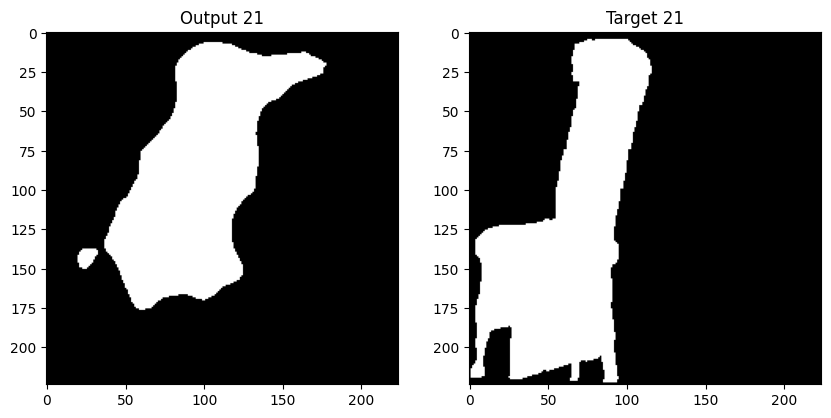

In [899]:
visualitza_resultats()